## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.datasets import cifar10
import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [3]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [4]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, regularization, ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    if regularization == "l1":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(ratio))(x)
    elif regularization == "l2":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(ratio))(x)
    else:
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [5]:
# 設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
REGULARIZATION = ["l1", "l2", "l1_l2"]
EXP = [1e-2, 1e-4, 1e-8]

In [6]:
results = {}

for regularization in REGULARIZATION:
    for regulizer_ratio in EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f"Regularization: {regularization}, Ratio: {regulizer_ratio}")
        model = build_mlp(input_shape=x_train.shape[1:], regularization=regularization, ratio=regulizer_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "Regularization: %s, Ratio: %s" % (regularization, str(regulizer_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Regularization: l1, Ratio: 0.01
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 

196/196 [==============================] - 5s 24ms/step - loss: 2.6759 - accuracy: 0.6235 - val_loss: 2.9402 - val_accuracy: 0.5239
Epoch 50/50
196/196 [==============================] - 5s 24ms/step - loss: 2.6438 - accuracy: 0.6251 - val_loss: 2.9034 - val_accuracy: 0.5265
Regularization: l1, Ratio: 1e-08
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense) 

196/196 [==============================] - 5s 25ms/step - loss: 1.6211 - accuracy: 0.5229 - val_loss: 1.6859 - val_accuracy: 0.4993
Epoch 48/50
196/196 [==============================] - 5s 25ms/step - loss: 1.6184 - accuracy: 0.5242 - val_loss: 1.6909 - val_accuracy: 0.4897
Epoch 49/50
196/196 [==============================] - 5s 25ms/step - loss: 1.6144 - accuracy: 0.5233 - val_loss: 1.7058 - val_accuracy: 0.4895
Epoch 50/50
196/196 [==============================] - 5s 25ms/step - loss: 1.6092 - accuracy: 0.5266 - val_loss: 1.6838 - val_accuracy: 0.4990
Regularization: l2, Ratio: 0.0001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                         

196/196 [==============================] - 5s 24ms/step - loss: 0.9303 - accuracy: 0.6740 - val_loss: 1.5406 - val_accuracy: 0.4876
Epoch 46/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9107 - accuracy: 0.6798 - val_loss: 1.4512 - val_accuracy: 0.5120
Epoch 47/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9010 - accuracy: 0.6844 - val_loss: 1.4081 - val_accuracy: 0.5220
Epoch 48/50
196/196 [==============================] - 5s 25ms/step - loss: 0.8888 - accuracy: 0.6894 - val_loss: 1.4017 - val_accuracy: 0.5266
Epoch 49/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8781 - accuracy: 0.6930 - val_loss: 1.4210 - val_accuracy: 0.5222
Epoch 50/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8637 - accuracy: 0.6982 - val_loss: 1.4603 - val_accuracy: 0.5178
Regularization: l1_l2, Ratio: 0.01
Model: "model"
_________________________________________________________________
 Layer (type)                Out

196/196 [==============================] - 6s 30ms/step - loss: 1.7799 - accuracy: 0.4721 - val_loss: 1.7914 - val_accuracy: 0.4675
Epoch 44/50
196/196 [==============================] - 6s 30ms/step - loss: 1.7760 - accuracy: 0.4726 - val_loss: 1.7868 - val_accuracy: 0.4668
Epoch 45/50
196/196 [==============================] - 6s 30ms/step - loss: 1.7706 - accuracy: 0.4740 - val_loss: 1.8065 - val_accuracy: 0.4568
Epoch 46/50
196/196 [==============================] - 6s 30ms/step - loss: 1.7669 - accuracy: 0.4729 - val_loss: 1.8153 - val_accuracy: 0.4527
Epoch 47/50
196/196 [==============================] - 6s 30ms/step - loss: 1.7651 - accuracy: 0.4752 - val_loss: 1.7969 - val_accuracy: 0.4616
Epoch 48/50
196/196 [==============================] - 6s 30ms/step - loss: 1.7603 - accuracy: 0.4778 - val_loss: 1.8173 - val_accuracy: 0.4450
Epoch 49/50
196/196 [==============================] - 6s 30ms/step - loss: 1.7567 - accuracy: 0.4778 - val_loss: 1.7799 - val_accuracy: 0.4711
Epoc

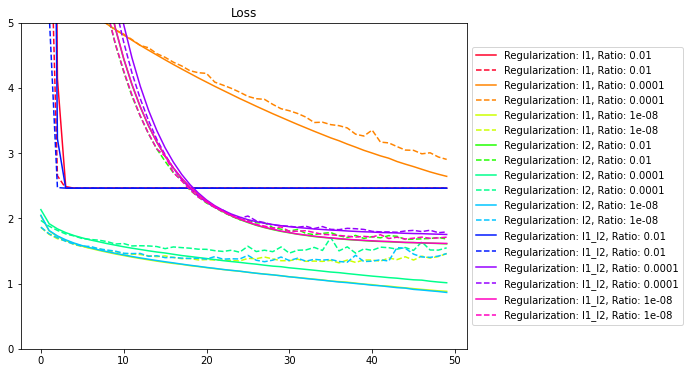

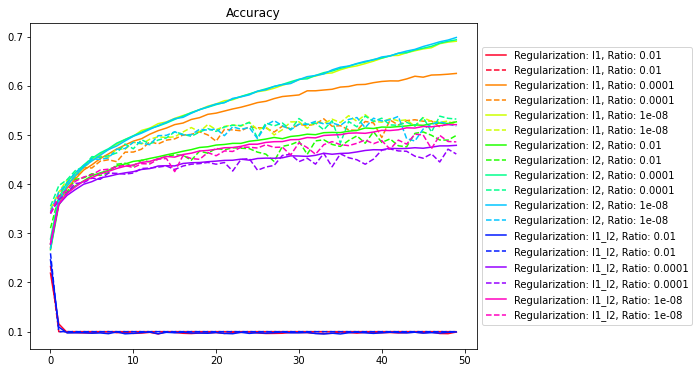

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 9

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()